# 畳み込みニューラルネットワーク

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from collections import OrderedDict

### im2col による展開

In [31]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

### col2im（im2col の逆伝播）

In [32]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

### ソフトマックス関数（出力層：分類問題）
$ y_k = \frac{exp(a_k)}{\sum_{i=1}^{n}exp(a_i)} $

In [33]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)  # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

### 交差エントロピー誤差（損失関数）
$ E = -\sum_{k}^{n}t_k log(y_k) $

In [34]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

### Convolution レイヤ（畳み込み層）

In [35]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

### ReLU レイヤ（活性化関数）
$ y = \begin{cases}
          x \quad (x > 0) \\
          0 \quad (x \leqq 0) \\
      \end{cases} $

In [36]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

### Pooling レイヤ（プーリング層）

In [37]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

### Affine レイヤ（全結合層）

In [38]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

### Softmax-with-Loss レイヤ（損失関数）
$ L = -\sum_{k}^{n}t_k log(\frac{exp(a_k)}{\sum_{i}^{n}exp(a_i)}) $

In [39]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

### MNIST データセット

In [40]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
print("x_train.shape [N, C, H, W]:", x_train.shape)
print("t_train.shape:", t_train.shape, t_train.dtype)

x_train.shape [N, C, H, W]: (60000, 1, 28, 28)
t_train.shape: (60000,) uint8


#### 【オプション】入力データの削減

In [41]:
sampled = 10000 # 高速化のため
x_train = x_train[:sampled]
t_train = t_train[:sampled]
print("x_train.shape [N, C, H, W]:", x_train.shape)
print("t_train.shape:", t_train.shape, t_train.dtype)

x_train.shape [N, C, H, W]: (10000, 1, 28, 28)
t_train.shape: (10000,) uint8


#### 【オプション】入力データの確認

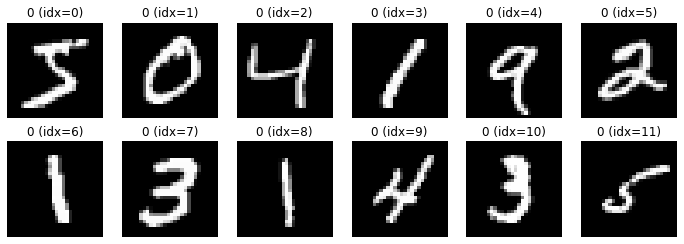

[5 0 4 1 9 2 1 3 1 4 3 5]


In [42]:
# 画像を表示
figure = plt.figure(figsize=(12, 4))
rows, cols = 2, 6
for i in range(rows * cols):
    img, label = x_train[i], t_train[i].argmax()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label} (idx={i})')
    plt.axis('off')
    img = img.reshape(28, 28)  # 784 -> 28x28 に変換
    plt.imshow(img, cmap='gray')
plt.show()
print(t_train[:rows * cols])

### ニューラルネットワークの定義

In [43]:
class SimpleConvNet:
    """単純なConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size : 隠れ層のニューロンの数（e.g. 100）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

### ニューラルネットワークのインスタンス化

In [44]:
network = SimpleConvNet(input_dim=(1,28,28),
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
print(network)

### パラメータの定義

In [45]:
epoch_num = 20  # エポック数を設定する
batch_size = 100  # バッチの数
learning_rate = 0.1  # 学習係数

### ミニバッチの学習

In [46]:
train_loss_list = []
train_acc_list = [0.0]
test_acc_list = [0.0]

train_size = x_train.shape[0]  # 訓練データの数
iter_per_epoch = max(int(train_size / batch_size), 1)  # エポック毎の繰り返しの回数
iters_num = iter_per_epoch * epoch_num  # 全体の繰り返しの回数

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    print(f'\rbatch({i % iter_per_epoch + 1}) loss = {train_loss_list[-1]}', end='')
    if (i + 1) % iter_per_epoch == 0:
        epoch_count = int((i + 1) / iter_per_epoch)
        print(f'\repoch({epoch_count}) loss = {train_loss_list[-1]}')
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f'epoch({epoch_count}) accuracy(train, test) = ({train_acc}, {test_acc})')

print('Done!')

epoch(1) loss = 2.294703107692676767
epoch(1) accuracy(train, test) = (0.1139, 0.1156)
epoch(2) loss = 0.587691956286300303
epoch(2) accuracy(train, test) = (0.7744, 0.7738)
epoch(3) loss = 0.2999171753535793737
epoch(3) accuracy(train, test) = (0.8665, 0.8643)
epoch(4) loss = 0.2255760375070554646
epoch(4) accuracy(train, test) = (0.918, 0.9094)
epoch(5) loss = 0.1646264286578238181
epoch(5) accuracy(train, test) = (0.9313, 0.9206)
epoch(6) loss = 0.1062576586158652727
epoch(6) accuracy(train, test) = (0.9363, 0.9256)
epoch(7) loss = 0.0964136286198607075
epoch(7) accuracy(train, test) = (0.9523, 0.9374)
epoch(8) loss = 0.04746638693548673636
epoch(8) accuracy(train, test) = (0.9584, 0.9441)
epoch(9) loss = 0.0568314127991580101
epoch(9) accuracy(train, test) = (0.9557, 0.9388)
epoch(10) loss = 0.066074721010509677
epoch(10) accuracy(train, test) = (0.9614, 0.9459)
epoch(11) loss = 0.033363592411185166
epoch(11) accuracy(train, test) = (0.9598, 0.9382)
epoch(12) loss = 0.0226565865118

### 損失関数の推移

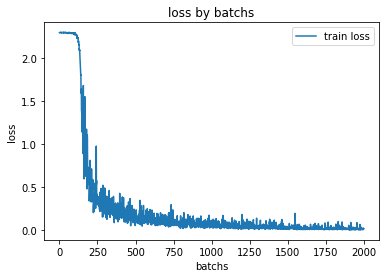

In [47]:
# グラフの描画
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel('batchs')
plt.ylabel('loss')
plt.title('loss by batchs')
plt.legend(loc='upper right')
plt.show()

### 認識精度の推移

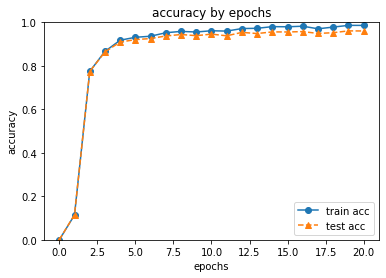

In [48]:
# グラフの描画
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc', marker='o')
plt.plot(x, test_acc_list, label='test acc', linestyle='--', marker='^')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy by epochs')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#### 【オプション】テストの結果

In [49]:
# テストの実行
test_predict = network.predict(x_test)
print(test_predict.shape)
for index in range(3):
    print(f'index = {index}')
    print(test_predict[index])
    print(t_test[index])

(10000, 10)
index = 0
[ -3.23329383  -5.39383184   6.45023655   8.11539464 -11.45039026
  -0.97871812 -13.53572165  17.56673581   0.12324857   2.05892928]
7
index = 1
[-0.23640066  1.97395669 14.21607184  3.61362377 -3.9519265  -2.59203758
  1.46182977 -9.5522618   0.40626129 -5.39922322]
2
index = 2
[-6.8016652   8.73064513  2.90686002 -1.11866689 -0.53855412 -1.99101553
 -0.06915752  2.49683522  1.20270779 -4.41286604]
1


#### 【オプション】エラー結果の確認

error rate = 3.9699999999999998[%] (num = 397/10000)


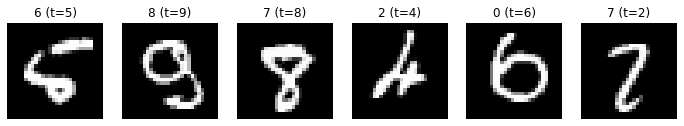

[[ 5.39421660e+00 -8.00534504e+00  2.71254846e+00 -9.77973412e+00
   4.71215584e+00  5.85921284e+00  9.63752671e+00 -1.16446125e+01
   3.13473766e+00 -1.35862744e+00]
 [ 1.16372851e+00 -6.24157189e+00  1.19778487e+00  3.64827824e+00
  -5.17328203e+00  1.38857663e+00 -7.93927141e+00  2.34892198e+00
   5.48440158e+00  4.96116907e+00]
 [-5.70806028e+00 -7.18742714e+00  2.13148090e+00  1.01181473e+01
  -8.96475374e+00  1.87914929e+00 -1.83840481e+01  1.14272932e+01
   8.37551800e+00  6.19022382e+00]
 [ 1.54777980e+00 -6.76656985e+00  9.46604201e+00 -4.76433313e-01
   7.12034176e+00 -7.60458657e-01  6.31356573e+00 -1.27174186e+00
  -5.49984766e+00 -9.99879482e+00]
 [ 1.09933949e+01 -5.02055203e+00 -2.73215967e+00 -5.77031556e+00
  -6.91391585e-01  1.00910055e+00  6.26376641e+00  1.77087868e-02
  -2.26225637e+00 -2.04034637e+00]
 [-4.85706711e+00  7.26925489e-01  8.73084362e+00  7.37340048e+00
  -1.13014307e+01 -3.98739580e+00 -1.24793807e+01  1.27613173e+01
   4.13697219e+00 -3.37311045e-01

In [50]:
# エラー結果の要素を抽出
index_error = np.argmax(test_predict, axis=1) != t_test
error_list = np.arange(len(test_predict))[index_error]
print(f'error rate = {len(error_list) / len(test_predict) * 100}[%]',
      f'(num = {len(error_list)}/{len(test_predict)})')

offset = 0
# 画像を表示
figure = plt.figure(figsize=(12, 2))
rows, cols = 1, 6
for i in range(rows * cols):
    index = error_list[offset + i]
    img, label_t, label_y = x_test[index], t_test[index], test_predict[index].argmax()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label_y} (t={label_t})')
    plt.axis('off')
    img = img.reshape(28, 28)  # 784 -> 28x28 に変換
    plt.imshow(img, cmap='gray')
plt.show()
print(test_predict[error_list[offset:offset + rows * cols]])